# These were implemente. may delete nb


In [408]:

from iros.io import fetch_simulation
from iros.mask import fetch_camera, CodedMaskCamera, _bisect_interval, encode
from iros.assets import _path_test_mask

import matplotlib.pyplot as plt
import numpy as np

wfm = fetch_camera(_path_test_mask, (5, 8))

In [409]:
def _shift(a: np.array, shift: tuple[int, int]):
    """Shifts a 2D numpy array by the specified amount in each dimension.
    Made a specialized one because it is significantly faster than scipy.ndimage, which
    does a lot of extra shit.

    Args:
        a: Input 2D numpy array to be shifted.
        shift: Tuple of (row_shift, column_shift) where positive values shift down/right
            and negative values shift up/left. Values larger than array dimensions
            result in an array of zeros.

    Returns:
        np.array: A new array of the same shape as the input, with elements shifted
            and empty spaces filled with zeros.

    Examples:
        >>> arr = np.array([[1, 2], [3, 4]])
        >>> _shift(arr, (1, 0))  # Shift down by 1
        array([[0, 0],
               [1, 2]])
        >>> _shift(arr, (0, -1))  # Shift left by 1
        array([[2, 0],
               [4, 0]])
    """
    n, m = a.shape
    shift_i, shift_j = shift
    if abs(shift_i) >= n or abs(shift_j) >= m:
        return np.zeros_like(a)
    vpadded = np.pad(a, ((0 if shift_i < 0 else shift_i, 0 if shift_i >= 0 else -shift_i), (0, 0)))
    vpadded = vpadded[:n, :] if shift_i > 0 else vpadded[-n:, :]
    hpadded = np.pad(vpadded, ((0, 0), (0 if shift_j < 0 else shift_j, 0 if shift_j >= 0 else -shift_j)))
    hpadded = hpadded[:, :m] if shift_j > 0 else hpadded[:, -m:]
    return hpadded



In [410]:
from scipy.ndimage import shift

a = np.arange(12).reshape(4, 3)
shift_ext = (-1, 0)
print(shift(a, shift_ext), "\n", _shift(a, shift_ext))

[[ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [ 0  0  0]] 
 [[ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [ 0  0  0]]


In [411]:
def shadowgram(camera: CodedMaskCamera, source_position: tuple[int, int]) -> np.array:
    """Fast computation of detector shadowgram for a point source.

    Shifts and crops the mask pattern to generate the detector response.
    The output is unnormalized and binary (ones and zeros).

    Args:
        camera: CodedMaskCamera instance containing mask pattern and geometry.
        source_position: Tuple of (i,j) integers specifying source position in sky coordinates,
            where (sky_shape[0]//2, sky_shape[1]//2) is the center.

    Returns:
        np.array: Binary detector shadowgram of shape (detector_height, detector_width).
    """
    i, j = source_position
    n, m = camera.sky_shape
    shift_i, shift_j = (n // 2 - i), (m // 2 - j)
    shifted_mask = shift(camera.mask, (shift_i, shift_j))
    bins_detector = camera.bins_detector
    bins_mask = camera.bins_mask
    i_min, i_max = _bisect_interval(bins_mask.y, bins_detector.y[0], bins_detector.y[-1])
    j_min, j_max = _bisect_interval(bins_mask.x, bins_detector.x[0], bins_detector.x[-1])
    return shifted_mask[i_min:i_max, j_min:j_max]


In [412]:
i, j = 8261 // 2, 8359 // 2
shadowgram__ = shadowgram(wfm, i, j)

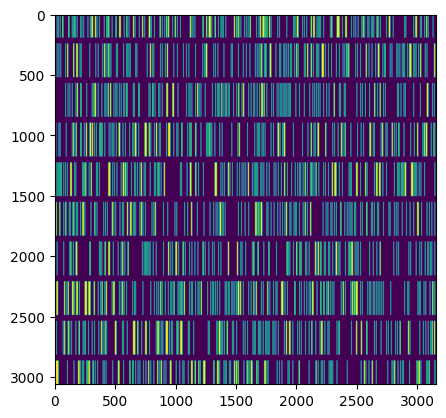

In [287]:
plt.imshow(shadowgram__)
plt.show()

In [288]:
def benchmark_shadowgram(camera: CodedMaskCamera, source_position: tuple[int, int]):
    i, j = source_position
    sky_model = np.zeros(camera.sky_shape)
    sky_model[i, j] = 1
    return np.round(encode(camera, sky_model)).astype(int)

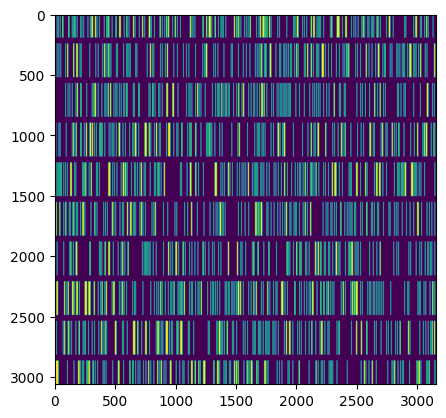

In [289]:
plt.imshow(shadowgram_)
plt.show()

In [290]:
print(len(shadowgram__ != shadowgram_))

3062


In [291]:
shadowgram__, shadowgram_

(array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]]),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]]))

In [292]:
np.all(shadowgram__ == shadowgram_)

np.True_

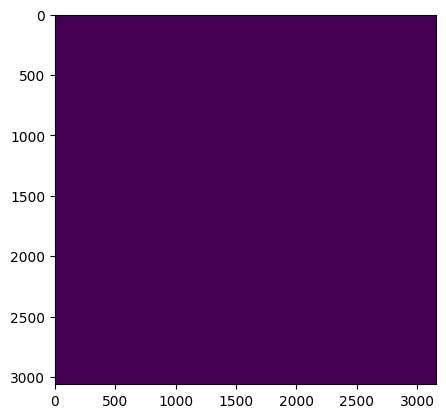

In [293]:
plt.imshow(shadowgram__ - shadowgram_)
plt.show()